# Homogenization of elastic properties of composites
The mechanical behavior of structures composed of phases with different properties can be estimated based on the theoretical models of Voigt and Reuss. In this tutorial, composites with a matrix and a filler phases are investigated with respect to their elastic properties. The results of the numerical simulation with the Finite Elemnt Method (FEM) are compared to the theoretical values. Finite Element Analysis is performed with the pyLabFEA package, see the <a rel="docs" href="https://ahartmaier.github.io/pyLabFEA/">online documentation</a> and the tutorial <a rel="Intro" href="https://ahartmaier.github.io/pyLabFEA/examples.html#tutorial-1-introduction">Introduction</a> for detailed information on the functionality of the package. For further studies on the behavior of linear-elastic composites, please open the tutorial <a rel="Comp" href="https://ahartmaier.github.io/pyLabFEA/examples.html#tutorial-2-composites">Composites</a>. 

This Jupyter notebook uses ipywidgets for user interactions, the matplotlib (https://matplotlib.org/) library for the visualization of results, and NumPy (http://www.numpy.org) for mathematical operations with arrays.

Author: Alexander Hartmaier, ICAMS / Ruhr-Universität Bochum, Germany

July 2025

This work is licensed under a Creative 
Commons Attribution-NonCommercial-ShareAlike 4.0 International License
<a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">(CC-BY-NC-SA)</a>
 <a rel="license" href="http://creativecommons.org/licenses/by-nc-sa/4.0/">
<img alt="Creative Commons License" style="border-width:0;max-heigt:9px;height:100%;" src="https://i.creativecommons.org/l/by-nc-sa/4.0/88x31.png" /></a>

The pyLabFEA package comes with ABSOLUTELY NO WARRANTY. This is free
software, and you are welcome to redistribute it under the conditions of
the GNU General Public License <a href="http://www.fsf.org/licensing/licenses/gpl.html">(GPLv3)</a> 

### Read libraries and define global objects

**Note: Cells must be run individually in sequence to allow for user-defined inputs.**

In [1]:
%matplotlib widget
import json
import pylabfea as FE
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets 


""" Define classes used in this notebook """

class ResultDB(object):
    """ Database object for mechanical properties and geometric parameters of filler phase of different composites.
    Properties of matrix and filler phase must remain constant, only volume fraction and shapes may change!
    """
    def __init__(self, E1, E2):
        self.properties = {
            'Phase_Prop' : {
                'E1' : E1,
                'E2' : E2
            },
            'VF' : [],
            'SH_x0': [],
            'SH_x1': [],
            'SH_y0': [],
            'SH_y1': [],
            'Corners' : [],
            'E_vert' : [],
            'E_hor' : [],
        }
        
    def add(self, vf, shp, cpairs, Ev, Eh, E1, E2):
        if not (np.isclose(E1, self.properties['Phase_Prop']['E1']) and np.isclose(E1, self.properties['Phase_Prop']['E1'])):
            print('ERROR: wrong material definition.')
            print(f"This database is for composites with E1={self.properties['Phase_Prop']['E1']}"
                  f"and E2={self.properties['Phase_Prop']['E2']}, values provided are for E1={E1} and E2={E2}")
        self.properties['VF'].append(float(vf))
        self.properties['SH_x0'].append(float(shp[0, 0]))
        self.properties['SH_x1'].append(float(shp[0, 1]))
        self.properties['SH_y0'].append(float(shp[1, 0]))
        self.properties['SH_y1'].append(float(shp[1, 1]))
        self.properties['E_vert'].append(float(Ev))
        self.properties['E_hor'].append(float(Eh))
        hh = cpairs.ravel()
        self.properties['Corners'].append(len(hh))
        for val in hh:
            self.properties['Corners'].append(float(val))

    def plot(self):
        # calculate theoretical values
        E1 = self.properties['Phase_Prop']['E1']
        E2 = self.properties['Phase_Prop']['E2']
        Ev = np.array(self.properties['E_vert'])
        Eh = np.array(self.properties['E_hor'])
        vf = np.array(self.properties['VF'])
        shx = np.array(self.properties['SH_x1'])
        shy = np.array(self.properties['SH_y1'])

        # calculate theoretical homogenization values
        x = np.linspace(0.0, 1.0, 50)
        yV = (1.0 - x) * E1  + x * E2  # Voigt value for Young's modulus of composite
        yR = 1 / ((1.0 - x) / E1 + x / E2)  # Reuss value

        # set colormap for shapes
        n_val = len(vf)
        cm = plt.get_cmap('bwr')  # blue to white to red colormap

        # generate plot
        fig = plt.figure()
        plt.plot(x, yV, ':k')
        plt.plot(x, yR, '--k')
        for i, val in enumerate(vf):
            plt.scatter(val, Ev[i], color=cm(0.5 + 0.5*shy[i]))
            plt.scatter(val, Eh[i], color=cm(0.5 - 0.5*shx[i]))
        #plt.colorbar()
        plt.xlabel('Filler volume fraction (.)')
        plt.ylabel("Eff. Young's modulus (GPa)")
        plt.legend(['Voigt rule', 'Reuss rule', 'E_vert', 'E_hor'])
        plt.title('Homogenized Stiffness')
        plt.show()
        return fig

    def write(self, fname=None, team=None):
        if fname is None:
            ttag = 'res_' if team is None else f'res_team{team}'
            fname = ttag + f"_{int(self.properties['Phase_Prop']['E1'])}_{int(elf.properties['Phase_Prop']['E2'])}.json"
        with open(fname, 'w') as fp:
            json.dump(self.properties, fp, indent=2)

    def read(self, fname):
        with open(fname, 'r') as fp:
            res = json.load(fp)
        for key, val in self.properties.items():
            if key == 'Phase_Prop':
                if val['E1'] != res[key]['E1'] or val['E2'] != res[key]['E2']:
                    raise valueError('Phase properties in file do not match those of this database. Cannot import.')
                continue
            val += res[key]


class Composite(object):
    def __init__(self, nel, etot, latbc, E1, nu1, E2, nu2):
        # Check of input values
        if E1 < 1 or E1 > 600:
            print(f"WARNING: Young's modulus E1 must be in range 1 ... 600 GPa, not {E1}. Using E1=10 GPa.")
            E1 = 10.0
        if E2 < 1 or E2 > 600:
            print(f"WARNING: Young's modulus E2 must be in range 1 ... 600 GPa, not {E2}. Using E2=300 GPa.")
            E2 = 300.0
        if nu1 < 0.2 or nu1 > 0.5:
            print(f"WARNING: Poisson's ratio nu1 must be in range 0.2 ... 0.5, not {nu1}. Using nu1=0.27.")
            nu1 = 0.27
        if nu2 < 0.2 or nu2 > 0.5:
            print(f"WARNING: Poisson's ratio nu2 must be in range 0.2 ... 0.5, not {nu2}. Using nu2=0.27.")
            nu2 = 0.27
        # set elastic material parameters
        """ Convert units from GPa to MPa """
        self.E1 = E1 * 1000.0  # Young's modulus of matrix in MPa
        self.nu1 = nu1  # Poisson's ratio of matrix
        self.E2 = E2 * 1000.0 # Young's modulus of filler phase in MPa
        self.nu2 = nu2  # Poisson's ratio of filler phase
        # set number of finite elements in regular mesh
        self.NX = nel
        self.NY = nel
        # define boundary conditions
        self.sides = 'force' if latbc == 'free' else 'disp'  # free or fixed lateral BC
        """ Convert strain units from percent to dimensionless """
        self.eps_tot = etot*0.01  # total strain in y-direction
        
        # define phases on composite materials
        self.mat1 = FE.Material(num=1, name="matrix")  # call class to generate material object
        self.mat1.elasticity(E=E1, nu=nu1)  # define elastic properties
        self.mat2 = FE.Material(num=2, name="filler")  # define second material
        self.mat2.elasticity(E=E2, nu=nu2)  # material is purely elastic# setup model for elongation in y-direction

        # calculate stress-strain curves of individual phases
        self.mat1.calc_properties(eps=self.eps_tot, sigeps=True)  # invoke method to calculate properties of material 
        self.mat2.calc_properties(eps=self.eps_tot, sigeps=True)  # and to store stress-strain data up to total strain eps=1%

        # initialize variables for FE model
        self.el = None
        self.fe = None
        
        # handels for plots
        self.p_set = set()

    def create_model(self):
        # predefine model with only matrix material
        self.el = np.ones((self.NX, self.NY),dtype=int)
        
        # create and plot model
        self.fe = FE.Model(dim=2, planestress=True)  # initialize finite element model
        self.fe.geom(sect=2, LX=10., LY=10.)  # define geometry with two sections
        self.fe.assign([self.mat1, self.mat2])  # assign materials to sections
        self.fe.mesh(elmts=self.el, NX=self.NX, NY=self.NY)  # create regular mesh with sections as defined in el

    def tensile(self, axis):
        self.fe.u = None  # erase old solutions
        if axis.lower() in ['horizontal', 'horiz', 'hor', 'h']:
            # boundary conditions: uniaxial stress in horizontal direction
            self.fe.bcleft(0.)  # fix left boundary
            self.fe.bctop(0., self.sides)  # boundary condition on lateral edges of model
            self.fe.bcbot(0., self.sides)
            self.fe.bcright(self.eps_tot * self.fe.lenx, 'disp')  # strain applied to rhs nodes
            if self.sides == 'force':
                # fix lateral displacements of corner node to prevent rigid body motion
                hh = [no in self.fe.nobot for no in self.fe.noleft]
                noc = np.nonzero(hh)[0]  # find corner node
                self.fe.bcnode(noc, 0., 'disp', 'y')  # fix lateral displacement
            self.fe.solve()  # calculate distortions of composite under boundary conditions in mechanical equilibrium 
        elif axis.lower() in ['vertical', 'vert', 'v']:
            # boundary conditions: uniaxial stress in vertical direction
            self.fe.bcbot(0.)  # fix bottom boundary
            self.fe.bcright(0., self.sides)  # boundary condition on lateral edges of model
            self.fe.bcleft(0., self.sides)
            self.fe.bctop(self.eps_tot * self.fe.leny, 'disp')  # strain applied to top nodes
            if self.sides == 'force':
                # fix lateral displacements of corner node to prevent rigid body motion
                hh = [no in self.fe.nobot for no in self.fe.noleft]
                noc = np.nonzero(hh)[0]  # find corner node
                self.fe.bcnode(noc, 0., 'disp', 'x')  # fix lateral displacement
            self.fe.solve()
        else:
            raise ValueError(f'Axis must be either "horizontal" or "vertical", not "{axis}"')
        # return stress and strain values
        return self.fe.sgl, self.fe.egl

    def calc_geom_param(self):
        ind_x, ind_y = np.nonzero(self.el == 2)
        n_fil = len(ind_x)
        vf = n_fil / (self.NX*self.NY)  # volume fraction of filler phase
        ind_set = set()
        for i in range(n_fil):
            ind_set.add(f'{ind_x[i]}_{ind_y[i]}')
        lpx = []
        lpy = []
        for i in range(n_fil):
            nl = f'{ind_x[i]-1}_{ind_y[i]}' in ind_set
            nr = f'{ind_x[i]+1}_{ind_y[i]}' in ind_set
            nd = f'{ind_x[i]}_{ind_y[i]-1}' in ind_set
            nu = f'{ind_x[i]}_{ind_y[i]+1}' in ind_set
            if nl and nr and nd and nu:
                continue
            nc = 1
            if nl and not nr:
                while nl:
                    nc += 1
                    nl = f'{ind_x[i]-nc}_{ind_y[i]}' in ind_set
                lpx.append(nc)
                nc = 1
            if nu and not nd:
                while nu:
                    nc += 1
                    nu = f'{ind_x[i]}_{ind_y[i]+nc}' in ind_set
                lpy.append(nc)
                nc = 1
        shape = np.zeros((2,2))
        if len(lpx) > 0:
            shape[0, 0] = min(lpx)/self.NX
            shape[0, 1] = max(lpx)/self.NX
        if len(lpy) > 0:
            shape[1, 0] = min(lpy)/self.NY
            shape[1, 1] = max(lpy)/self.NY
        return vf, shape

    def upd_model(self, coords):
        p0 = coords[-2]
        p1 = coords[-1]
        ix = [int(p0[0] * self.NX / 10), int(p1[0] * self.NX / 10)]
        iy = [int(p0[1] * self.NY / 10), int(p1[1] * self.NY / 10)]
        NXi1 = min(ix)
        NXi2 = max(ix) + 1
        NYi1 = min(iy)
        NYi2 = max(iy) + 1
        self.el[NXi1:NXi2, NYi1:NYi2] = 2
        self.fe.mesh(elmts=self.el, NX=self.NX, NY=self.NY)  # create regular mesh with sections as defined in el
        return NXi1, NXi2, NYi1, NYi2

    def plot(self, val, mag=4, fig=None, ax=None):
        bar = False if val=='mat' else True
        fig, ax = self.fe.plot(val, mag=mag, shownodes=False, showbar=bar,
                               showfig=False, fig=fig, ax=ax)
        plt.show()
        self.p_set.add(fig)
        return fig, ax

    def close_plots(self):
        for p in self.p_set:
            plt.close(p)
        self.p_set = set()


""" Define global functions for widget actions """

def update_info_widget(vf, shp):
    global vf_widget, shape_widget
    vf_widget.value = f'{vf*100:5.1f}%'
    shape_widget.value = f'X0: {shp[0, 0]:5.3f}, X1: {shp[0, 1]:5.3f} | Y0: {shp[1, 0]:5.3f}, Y1: {shp[1, 1]:5.3f}'


def update_model(button):
    global comp, coords, cpairs, fig, ax
    x0, y0, x1, y1 = comp.upd_model(coords)
    cpairs.append([x0, y0, x1, y1])
    fig, ax = comp.plot(val='mat', mag=1, fig=fig, ax=ax)
    vf, shape = comp.calc_geom_param()
    update_info_widget(vf, shape)
    coords = []  # reset clicked coordinates

    
def erase_model(button):
    global comp, coords, cpairs, fig, ax
    comp.create_model()
    fig, ax = comp.plot(val='mat', mag=1, fig=fig, ax=ax)
    coords = []
    cpairs = []
    vf = 0.0
    shape = np.zeros((2,2), dtype=int)
    update_info_widget(vf, shape)


def finish_model(button):
    global comp, coords, cpairs, fig, ax, cid
    if len(coords) > 1:
        x0, y0, x1, y1 = comp.upd_model(coords)
        cpairs.append([x0, y0, x1, y1])
        fig, ax = comp.plot(val='mat', mag=1, fig=fig, ax=ax)
        vf, shape = comp.calc_geom_param()
        update_info_widget(vf, shape)
    coords = []
    #deactivate buttons for user interaction
    fig.canvas.mpl_disconnect(cid)
    update_btn.disabled = True
    erase_btn.disabled = True
    finish_btn.disabled = True


def coord_click(event):
    global coords
    coords.append([event.xdata, event.ydata])


"""  Define variables and boxes for widgets  """

# Info widgets for results on geometrical arrangement of filler phase
vf_widget = widgets.Text(value='0.0 %', 
                         description='Volume fraction filler:',
                         disabled=True, style={'description_width':'160px'})
shape_widget = widgets.Text(value='X0: 0.0, X1: 0.0 | Y0: 0.0, Y1: 0.0',
                            description='Shape parameters:',
                            disabled=True, style={'description_width':'160px'},
                            layout=widgets.Layout(width='500px'))

# Buttons for interactive material definition
update_btn = widgets.Button(description="Update", disabled=False, layout=widgets.Layout(width='210px'))
erase_btn = widgets.Button(description="Erase", disabled=False, layout=widgets.Layout(width='210px'))
finish_btn = widgets.Button(description="Finish", disabled=False, layout=widgets.Layout(width='210px'))

# Link buttons to their respective functions
update_btn.on_click(update_model)
erase_btn.on_click(erase_model)
finish_btn.on_click(finish_model)

# Labels for boxes in user interface for parameter definitions
label_model = widgets.Label(value="Model", 
                            style = {'background' : '#CEDF9F','font_size':'19px','font_weight':'bold'},
                            layout=widgets.Layout(padding = '0px 80px'))
label_material = widgets.Label(value="Material properties", 
                               style = {'background' : '#CEDF9F','font_size':'19px','font_weight':'bold'},
                               layout=widgets.Layout(padding = '0px 80px'))
label_mesh = widgets.Label(value="Mesh", 
                           style = {'background' : '#EAF5B8','font_size':'17px'},
                           layout=widgets.Layout(padding = '0px 80px'))
label_bc = widgets.Label(value="Boundary Conditions", 
                         style = {'background' : '#EAF5B8','font_size':'17px'},
                         layout=widgets.Layout(padding = '0px 80px'))
label_matrix = widgets.Label(value="Matrix", 
                             style = {'background' : '#EAF5B8','font_size':'17px'},
                             layout=widgets.Layout(padding = '0px 80px'))
label_filler = widgets.Label(value="Filler", 
                             style = {'background' : '#EAF5B8','font_size':'17px'},
                             layout=widgets.Layout(padding = '0px 80px'))

# Widgets for model and material parameter definitions
nel_widget = widgets.IntText(value=30, description="Elements per side: ", style={'description_width':'160px'})
sides_widget = widgets.Dropdown(description="Lateral boundary: ",options=['free', 'fixed'], style={'description_width':'160px'})
etot_widget = widgets.FloatText(value=1, description="Total strain (%): ", style={'description_width':'160px'})

E1_widget = widgets.FloatText(value=10.0, description="Young's modulus (GPa): ", style={'description_width':'160px'})
nu1_widget = widgets.FloatText(value=0.27, description="Poisson's ratio (.): ", style={'description_width':'160px'})
E2_widget = widgets.FloatText(value=300.0, description="Young's modulus (GPa): ", style={'description_width':'160px'})
nu2_widget = widgets.FloatText(value=0.27, description="Poisson's ratio (.): ", style={'description_width':'160px'})

model_box = widgets.VBox([label_model, 
                          label_mesh, nel_widget,
                          label_bc, etot_widget, sides_widget], 
                         layout=widgets.Layout(border='solid 2px #A1D6B2', padding='10px', margin='10px'))
material_box = widgets.VBox([label_material, 
                             label_matrix, E1_widget, nu1_widget,
                             label_filler, E2_widget, nu2_widget], 
                            layout=widgets.Layout(border='solid 2px #A1D6B2', padding='10px', margin='10px'))

#define user interfaces
ui_mat = widgets.VBox([widgets.HBox([material_box, model_box])], layout=widgets.Layout(padding='10px', margin='20px'))
ui_comp = widgets.VBox([widgets.HBox([vf_widget, shape_widget]), 
                    widgets.HBox([update_btn, erase_btn, finish_btn])],
                   layout=widgets.Layout(padding='10px', margin='20px'))


The scikit-learn intel acceleration is not installed on your system


## 1. Create simulation model and specifiy properties of matrix and filler materials

In the first step, basic elements of the Finite Element Model of a composite material are defined. This requires the definition of the elastic properties of matrix and filler phases, as well as the definition of the finite element mesh and the boundary conditions for the simulation of mechanical behavior of the composite.

In [2]:
"""
Unit system for this Notebook:
Young's modulus: 1 GPa
Strain: 1 %

Unit system for pyLabFEA:
Stress: 1 MPa
Strain: 1 (dimensionless)
Length: 1 mm
"""

display(ui_mat)


In the next step, the finite element model `comp` is created based on the user input and a database object `prop` for the properties resulting from finite element simulations of tensile tests on the composite is initialized.

In [4]:
# define object for composite model based on user-defined paramatere
comp = Composite(nel=nel_widget.value,
                 etot=etot_widget.value,
                 latbc=sides_widget.value,
                 E1=E1_widget.value,
                 nu1=nu1_widget.value,
                 E2=E2_widget.value,
                 nu2=nu2_widget.value)

#define object for mechanical properties of different composite materials
prop = ResultDB(E1_widget.value, E2_widget.value)

## 2. Define geometrical arrangement of filler phase
In this step, a finite element model of a composite with 100% matrix phase is created. The user can specify the geometrical arrangement of the regions to which the filler phase should be assigned by clicking on the finite element in the upper left corner and the finite element in the lower right corner of the rectangle to be changed into filler phase. By pressing the button `Update` the elements containing the filler phase will be displayed in yellow, while the matrix phase is displayed in purple. Note that only the last two points clicked will be used. With the button `Erase` the complete choice can be removed and all finite elements will be assigned again to matrix phase. The button `Finish` will finalize the choice of the geometrical arrangement of the filler phase and deactivate all buttons to avoid further changes.  
During update and finish operations, the volume fraction of filler phase and the shape parameter of the geometrical arrangement will be analysed and printed. The volume fraction is defined as the number of finite elements assigned to filler phase divided by the total number of finite elements. The shape parameter correspnd to the so-called lineal path function analysis of the geometrical arrangement. During this analysis, the $x$ and $y$-sizes of all regions assigned to filler phase will be evaluated and the minimum and maximum size in each direction is used as a shape parameter.

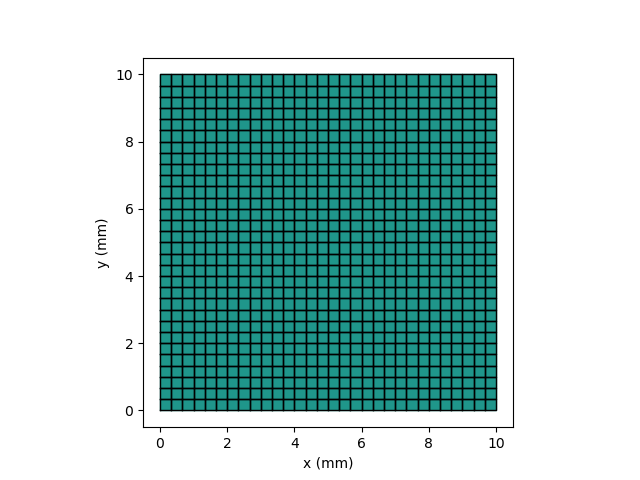

In [9]:
# create and plot initial model
comp.create_model()  # create model with 100% matrix phase
fig, ax = comp.plot('mat', mag=1)  # plot model geometry
update_info_widget(vf=0.0, shp=np.zeros((2,2), dtype=int))

# activate buttons for user interaction
cid = fig.canvas.mpl_connect('button_press_event', coord_click)  # record user clicks in model
update_btn.disabled = False
erase_btn.disabled = False
finish_btn.disabled = False

# start graphical user interface
coords = []  # initialize list of clicked coordinates
cpairs = []  # initialize list of corners of filler regions
display(ui_comp)

## 3. Perform finite element simulation of tensile test
In this step, a tensile test on the composite structure is simulated with the finite element method. As a results, the stresses and strain during the tensile test are returned, which will be used later to plot the stress-strain curves. Furthermore, the different stress components within the microstructure of the composite at maximum load are plotted.  
First, a tensile test in vertical direction is simulated and evaluated.  
**Note:** The use of the "%matplotlib widget" option require that all plots are closed, because otherwise they will remain active in the background and consume too much memory capacity.

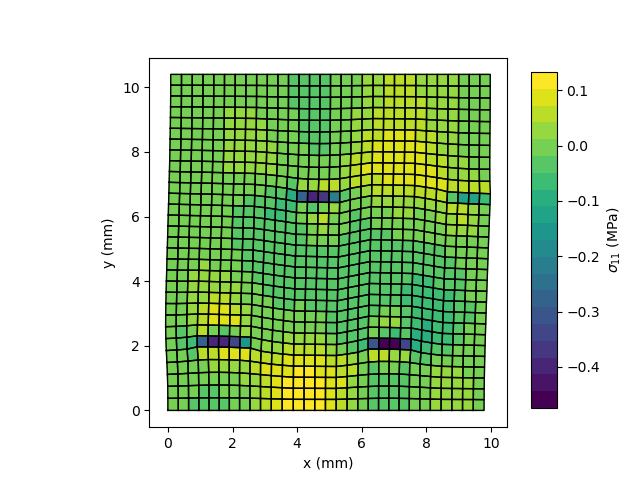

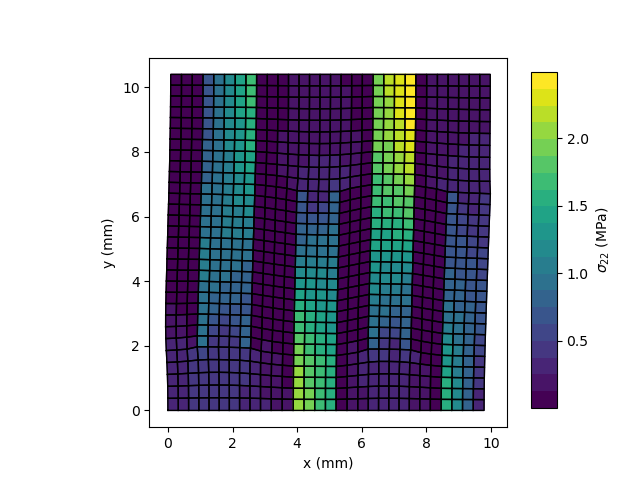

In [10]:
comp.close_plots()

# perform tensile test in vertical direction
sig_vert, eps_vert = comp.tensile('vertical')
fig, ax = comp.plot('stress1')
fig, ax = comp.plot('stress2')

Second, a tensile test in horizontal direction is performed.

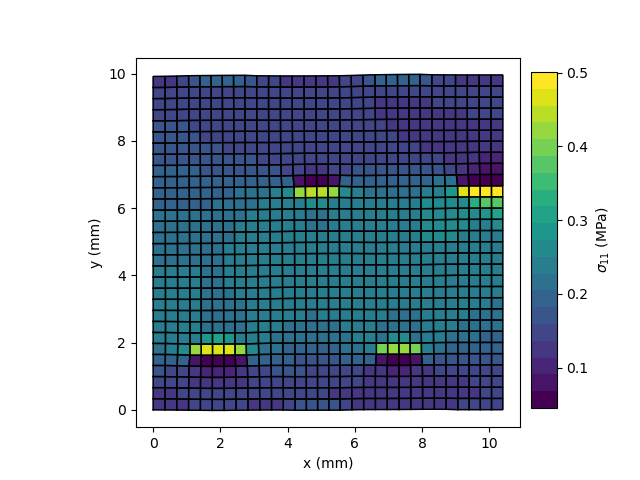

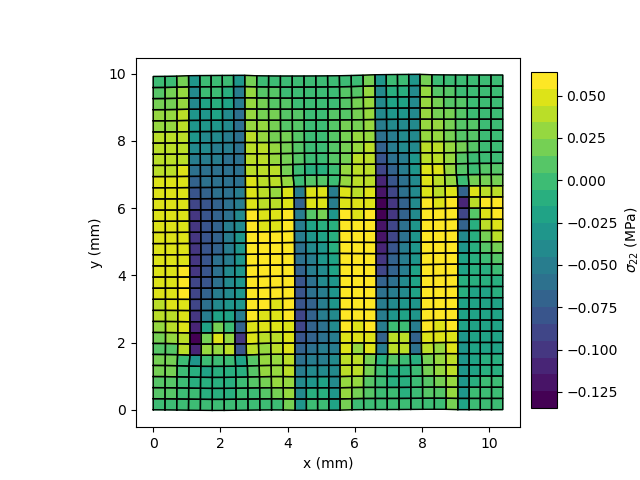

In [11]:
comp.close_plots()

# perform tensile test in horizontal direction
sig_hor, eps_hor = comp.tensile('horizontal')
fig, ax = comp.plot('stress1')
fig, ax = comp.plot('stress2')


Plot stress-strain curves for both loading directions and compare them to the stress-strain curves of matric and filler phases.

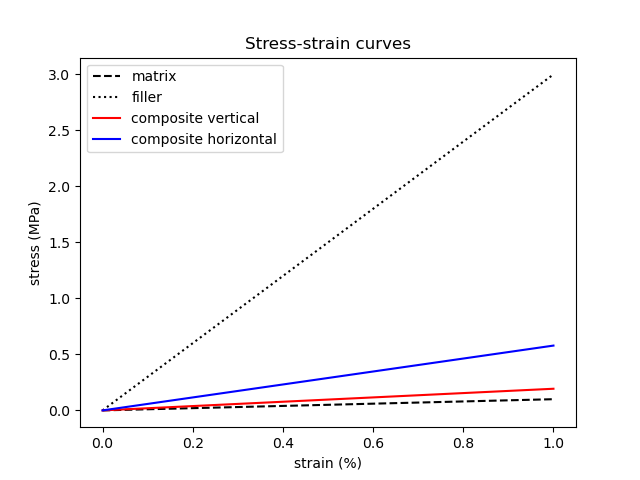

In [12]:
comp.close_plots()

# plot stress-strain curves of matrix, filler and composite in different loading directions
fig = plt.figure()
plt.plot(comp.mat1.sigeps['sty']['eps'][:, 1]*100,
         comp.mat1.sigeps['sty']['sig'][:, 1],
         '--k', label=comp.mat1.name)  # plot equiv. strain (eeq) vs. equiv. stress (seq)
plt.plot(comp.mat2.sigeps['sty']['eps'][:, 1]*100,
         comp.mat2.sigeps['sty']['sig'][:, 1],
         ':k', label=comp.mat2.name)  # for uniaxial tensile stress in vertical direction (sty)
plt.plot(eps_hor[:,0]*100., sig_hor[:,0], '-r', label='composite vertical')
plt.plot(eps_vert[:,1]*100., sig_vert[:,1], '-b', label='composite horizontal')
plt.title('Stress-strain curves')
plt.xlabel(r'strain (%)')
plt.ylabel(r'stress (MPa)')
plt.legend()
plt.show()


## 4. Add values of this composite to database
In the final step, the effective Young's modulus of the composite with the current geometrical arrangement of the filler phase is calculated from the stress-strain data. In this way, the elastic properties for loading in vertical and horizontal direction are obtained and stored in the results database, together with the geometry information on volume fraction and shape parameters.  
This data will be used later for the training of a machine learning model that predicts the elastic properties of a composte material with an arbitrary arrangement of the filler phase.

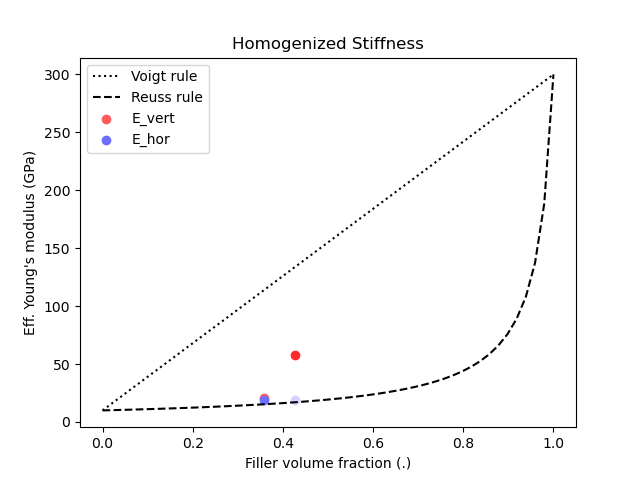

In [13]:
plt.close(fig)

# calculate Young's moduli in different directions
E_vert = (sig_vert[-1, 1] - sig_vert[0, 1]) /  (eps_vert[-1, 1] - eps_vert[0, 1])
E_hor = (sig_hor[-1, 0] - sig_hor[0, 0]) /  (eps_hor[-1, 0] - eps_hor[0,0 ])

# evaluate volume fraction and shape parameters
vf, shape = comp.calc_geom_param()
cpairs = np.array(cpairs) / nel_widget.value

prop.add(vf, shape, cpairs, E_vert, E_hor, E1_widget.value, E2_widget.value)
#prop.read('results_10_300.json')
fig = prop.plot()

In [10]:
plt.close(fig)

# save results database for future use
prop.write(fname='results_10_300.json')

## 5. Repeat calculations for different filler geometries
Please repeat the different steps, starting from Section 2 to Section 4 of this notebook. Test many different volume fractions and geometrical arrangements of the filler phase to obtain a good understanding of the elastic properties of composites. Furthermore, the data you generate here will be used later for training a machine learning model predicting the elastic properties of a composite.